## Generative Adverserial Network

### Implementing WGAN-GP to train the DCGAN model

#### **Key Drawbacks of Vanilla GAN**

This is a great paper to read on the problems of Vanilla GAN [Source: *Why are Generative Adversarial Networks so Fascinating and Annoying?*](https://ieeexplore.ieee.org/document/9266012/)

   - **Mode Collapse**:
     - *What it is*: Mode collapse occurs when the Generator starts producing very similar outputs regardless of input variation. This causes it to ignore certain parts of the data distribution, leading to a lack of diversity in generated samples.
     - *Why it happens*: The adversarial training can make the Generator overfit to a few patterns the Discriminator fails to distinguish, resulting in repetitive outputs.

   - **Training Instability**:
     - *What it is*: GAN training is notoriously unstable, with the Generator and Discriminator often oscillating without convergence.
     - *Why it happens*: The loss function doesn’t offer a clear gradient signal, often making it hard to strike a balance in the adversarial game. Tiny changes can lead to massive shifts in both the Generator’s and Discriminator’s behaviors, making tuning difficult.

   - **Vanishing Gradient Problem**:
     - *What it is*: When the Discriminator becomes too strong, it easily classifies fake samples, leading to very small gradients for the Generator. Consequently, the Generator’s updates become negligible, halting improvement.

     - *Why it happens*: The traditional cross-entropy loss used in GANs can suffer from saturating gradients when the Discriminator outperforms the Generator.

---


#### **Wasserstein Distance: A Better Metric for GANs**
The **Wasserstein distance (Earth Mover’s Distance)** is a metric that measures the "effort" needed to transform one distribution into another. It provides a more meaningful way to measure the similarity between the real and generated data distributions. Unlike traditional GAN loss, which uses Jensen-Shannon divergence, the Wasserstein distance leads to more stable gradients, enabling more consistent training.

---

#### **Kantorovich-Rubinstein Duality**
WGAN uses the **Kantorovich-Rubinstein duality** to approximate the Wasserstein distance between two distributions:

$$
W(P, Q) = \sup_{\|f\|_L \leq 1} (\mathbb{E}_{x \sim P}[f(x)] - \mathbb{E}_{y \sim Q}[f(y)])
$$

where \( P \) and \( Q \) are the real and generated distributions, and the supremum is taken over all **1-Lipschitz** functions \( $f$ \). You want to find the function
 $f$ that maximizes the difference in expectations between real and fake data.

In Wasserstein GAN (WGAN), the **Discriminator** (called the **Critic**) is trained to approximate the 1-Lipschitz function $f$, assigning higher scores to real samples and lower scores to generated ones. The difference in the Critic's outputs for real and generated samples estimates the Wasserstein distance between the two distributions. The **Generator** is then trained to minimize this distance by producing samples that maximize the Critic's score, effectively pushing the generated distribution closer to the real one.


---

#### **How WGAN Overcomes GAN Challenges**

   - **Overview of WGAN**: The WGAN model replaces the traditional cross-entropy loss with the Wasserstein loss, also known as the Earth-Mover distance, which measures the distance between real and generated data distributions more effectively. [Source: *Wasserstein GAN*](https://arxiv.org/abs/1701.07875)
   - **Advantages of WGAN**:
     - *Better Gradient Flow*: By minimizing the Wasserstein distance, WGAN ensures that the gradient signal remains robust even when the Discriminator excels. This helps avoid the vanishing gradient problem and leads to more stable training.
     - *Less Mode Collapse*: WGAN's loss function provides smoother gradients, reducing mode collapse issues. The Wasserstein distance gradually pulls the Generator closer to producing realistic samples across diverse outputs.
     - *Clip Weights for Stability*: the original WGAN implemented weight clipping in the Discriminator to ensure that it adheres to a Lipschitz constraint, which was thought to be crucial for calculating the Wasserstein distance and further stabilizing the training. This approach was later found to be problematic — it can lead to underfitting and limit the Critic’s capacity. The WGAN-GP (with Gradient Penalty) is a more standard approach. See next comment.
   
   - **Limitations of WGAN**:
     - *Weight Clipping Sensitivity*: Setting the clipping range is delicate; inappropriate values can still lead to gradient issues. To address this, further improvements (e.g., WGAN-GP) introduced gradient penalty to enforce the Lipschitz constraint more naturally.

With WGAN we still have exploding gradients problem due to the clipping of weights of the `critic' (Discriminator).

We will be implementing Wasserstein GAN with Gradient Penalty


---

### **Wasserstein GAN with Gradient Penalty (WGAN-GP)**

The WGAN minimizes the **Wasserstein distance** (or Earth Mover's Distance, EMD) between the real and generated data distributions, providing better gradient flow and addressing some of GAN’s limitations.

However, implementing WGAN comes with its own challenges, specifically enforcing the **1-Lipschitz constraint** on the discriminator, which is necessary to approximate the Wasserstein distance. The **Wasserstein GAN with Gradient Penalty (WGAN-GP)** improves upon WGAN by using a **gradient penalty** to enforce the 1-Lipschitz constraint on the Critic, leading to even more stable training and higher-quality results.

---

#### **Enforcing the 1-Lipschitz Constraint: WGAN vs. WGAN-GP**
For the Kantorovich-Rubinstein duality to hold, $ f $ must be 1-Lipschitz, meaning the Critic’s gradient norm should be at most 1. **WGAN** originally enforced this by **clipping the weights** of the Critic to a small range (e.g., $[-0.01, 0.01]$), but this led to degraded performance and limited capacity for the Critic.

**WGAN-GP** introduced an improved approach, using a **gradient penalty** to enforce the 1-Lipschitz constraint in a smoother and more stable way.

---

#### **How WGAN-GP Works**

#### 1. Gradient Penalty
The **gradient penalty** enforces the 1-Lipschitz constraint by penalizing the norm of the gradients of the Critic’s output with respect to its input. This is done as follows:

1. **Interpolate Between Real and Generated Samples**:
   - For each pair of real and generated samples, an **interpolated sample** is created by linearly interpolating between the real and fake data points.
   - The interpolated data point $ \text{interpolated} $ is computed as:

     $$
     \text{interpolated} = \alpha \cdot \text{real} + (1 - \alpha) \cdot \text{generated}
     $$
     where $ \alpha $ is a random number between 0 and 1.

2. **Compute the Critic’s Output on Interpolated Samples**:
   - The Critic outputs a score for these interpolated samples.

3. **Compute the Gradient of the Critic’s Output**:
   - The gradient of the Critic’s output with respect to the interpolated sample is calculated. The norm of this gradient (i.e., its magnitude) should ideally be close to 1.

4. **Apply the Gradient Penalty**:
   - The penalty term is computed as:

     $$
     \text{gradient penalty} = \lambda \cdot \mathbb{E}\left[(\|\nabla_{\text{interpolated}} D(\text{interpolated})\|_2 - 1)^2\right]
     $$
     where $ \lambda $ is a coefficient that controls the strength of the penalty.

#### 2. **WGAN-GP**

In WGAN-GP, the total system optimization involves two distinct losses: the Critic loss, which includes the Kantorovich-Rubinstein dual expression and a gradient penalty to enforce the 1-Lipschitz condition; and the Generator loss, which minimizes the same dual expression. The Kantorovich-Rubinstein criterion is effectively split between these two objectives — the Critic tries to maximize it, and the Generator tries to minimize it.


$$
L_D = \mathbb{E}_{x \sim P_\text{real}} [D(x)] - \mathbb{E}_{y \sim P_\text{gen}} [D(y)] + \text{gradient penalty}
$$

This loss encourages the Critic to assign high scores to real samples and low scores to fake samples while enforcing the 1-Lipschitz constraint. The gradient penalty is part of the Critic’s loss.


The Generator’s objective is to minimize the Wasserstein distance, which is equivalent to:

$$
L_G = -\mathbb{E}_{y \sim P_\text{gen}} [D(y)]
$$

By minimizing this, the Generator attempts to produce samples that the Critic cannot distinguish from real samples.

---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import Image
%matplotlib inline

In [3]:
import torch


print(torch.__version__)
print("GPU Available:", torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"

2.6.0+cu124
GPU Available: True


In [4]:
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import torchvision
from torchvision import transforms


image_path = './'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])
mnist_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=True,
                                           transform=transform,
                                           download=True)

batch_size = 128

torch.manual_seed(1)
np.random.seed(1)

## Set up the dataset
from torch.utils.data import DataLoader
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size,
                      shuffle=True, drop_last=True)


In [6]:
!ls -lrth

total 8.0K
drwxr-xr-x 1 root root 4.0K Apr  7 13:43 sample_data
drwxr-xr-x 3 root root 4.0K Apr 10 15:25 MNIST


In [7]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size, 1, 1)*2 - 1
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size, 1, 1)
    return input_z

In [8]:
mode_z = 'uniform'
z_size = 100
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

image_size = (28, 28)

def create_samples(g_model, input_z, batch_size):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images+1)/2.0

In [9]:
def make_generator_network_wgan(input_size, n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters*4, 4, 1, 0,
                           bias=False),
        nn.InstanceNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        # InstanceNorm2d normalizes each sample (instance) independently, and channel-wise, across spatial dimensions (height and width).
        # More effective for tasks like style transfer and generative models, where batch statistics can introduce artifacts.
        # It normalizes each image and channel separately — not across the batch
        # https://pytorch.org/docs/stable/generated/torch.nn.InstanceNorm2d.html

        nn.ConvTranspose2d(n_filters*4, n_filters*2, 3, 2, 1, bias=False),
        #nn.InstanceNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*2, n_filters, 4, 2, 1, bias=False),
        #nn.InstanceNorm2d(n_filters),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh())
    return model

class DiscriminatorWGAN(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters, n_filters*2, 4, 2, 1, bias=False),
            #nn.InstanceNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*2, n_filters*4, 3, 2, 1, bias=False),
            #nn.InstanceNorm2d(n_filters*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*4, 1, 4, 1, 0, bias=False),
            #nn.Sigmoid()) Just let the output be raw real values to measure the Wasserstein distance
        )
    def forward(self, input):
        output = self.network(input)
        return output.view(output.size(0), -1)

In [10]:
n_filters = 32
z_size = 100
image_size = (28, 28)

gen_model = make_generator_network_wgan(z_size, n_filters).to(device)
disc_model = DiscriminatorWGAN(n_filters).to(device)

g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0002)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)

In [12]:
from torch.autograd import grad as torch_grad

from torch.autograd import grad as torch_grad
import torch
import matplotlib.pyplot as plt

def gradient_penalty(real_data, generated_data, lambda_gp=10, plot=False):
    batch_size = real_data.size(0)
    device = real_data.device  # Assume both real and fake are already on the same device

    # Sample random weights for interpolation between real and fake samples
    alpha = torch.rand(batch_size, 1, 1, 1, device=device, requires_grad=True)

    # Create interpolated data points
    # Each point is a mix between real and fake, to evaluate the critic's smoothness
    interpolated = alpha * real_data + (1 - alpha) * generated_data
    interpolated.requires_grad_(True)  # Ensure PyTorch tracks gradients w.r.t. interpolated

    # Pass interpolated data through the critic
    critic_scores = disc_model(interpolated)  # Output: shape [batch_size, 1]

    # Compute gradients of the critic's output w.r.t. interpolated inputs
    # grad_outputs = ones means: "take raw gradients, per sample"
    gradients = torch_grad(
        outputs=critic_scores,
        inputs=interpolated,
        grad_outputs=torch.ones_like(critic_scores),  # important trick: per-sample gradients
        create_graph=True,   # enables higher-order derivatives (needed for backprop through this)
        retain_graph=True,   # keeps the graph if used again (e.g., generator step follows)
        only_inputs=True     # deprecated, but keeps it tidy for older PyTorch versions: gradients only w.r.t. the inputs
    )[0]  # Extract the tensor from the returned tuple

    # Flatten each sample's gradient to compute its L2 norm
    gradients = gradients.view(batch_size, -1)              # Shape: [batch_size, num_elements]
    gradients_norm = gradients.norm(2, dim=1)               # L2 norm per sample

    # Optional: Plot gradient norms during training (for debugging/exploration)
    if plot:
        plt.plot(gradients_norm.detach().cpu().numpy())
        plt.title("Gradient Norms of Interpolated Samples")
        plt.xlabel("Sample Index")
        plt.ylabel("L2 Norm of Gradient")
        plt.show()

    # Compute the gradient penalty
    # Penalize how far the norm is from 1 (ideal Lipschitz constraint)
    penalty = ((gradients_norm - 1) ** 2).mean()            # Scalar
    return lambda_gp * penalty                              # Scale by lambda (default = 10)



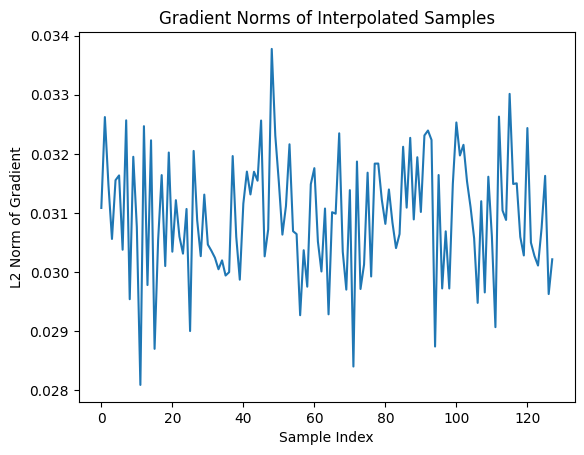

tensor(9.3907, device='cuda:0', grad_fn=<MulBackward0>)

In [13]:
# Lets test it
batch_size = 128
real_data = next(iter(mnist_dl))[0]
real_data = real_data.to(device)
input_z = create_noise(batch_size, z_size, mode_z).to(device)
generated_data = gen_model(input_z)

gradient_penalty(real_data, generated_data, plot = True)


In [14]:
## Train the discriminator

def d_train_wgan(x):
    disc_model.zero_grad()

    batch_size = x.size(0)
    x = x.to(device)

    # Generate fake samples
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)

    # Compute critic scores
    d_real = disc_model(x)
    d_generated = disc_model(g_output)

    # WGAN-GP loss: maximize real - fake, penalize Lipschitz violations
    gp = gradient_penalty(x.detach(), g_output.detach())
    d_loss = d_generated.mean() - d_real.mean() + gp

    # Update Critic
    d_loss.backward()
    d_optimizer.step()

    return d_loss.item()


In [15]:
## Train the generator

def g_train_wgan(x):
    gen_model.zero_grad()

    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)

    # Critic score for generated data
    d_generated = disc_model(g_output)

    # Generator loss (want the Critic to rate fake as real → high score)
    g_loss = -d_generated.mean()

    # Backprop and update Generator only
    g_loss.backward()
    g_optimizer.step()

    return g_loss.item()



In [18]:
# Helper function to display generated images
def show_generated_images(images, epoch=None):
    images = (images + 1) / 2  # Rescale from [-1, 1] to [0, 1]

    images = 1 - images # black hand-written digits on white background

    # Ensure shape is [N, C, H, W]
    if images.dim() == 3:  # If shape is [N, H, W], unsqueeze channel
        images = images.unsqueeze(1)

    grid = torchvision.utils.make_grid(images, nrow=4, padding=2, pad_value=1.0)


    npimg = grid.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(6, 6))
    plt.imshow(npimg.squeeze(), cmap='gray', interpolation='none')  # no smoothing
    plt.axis("off")
    if epoch is not None:
        plt.title(f"Epoch {epoch}")
    plt.show()



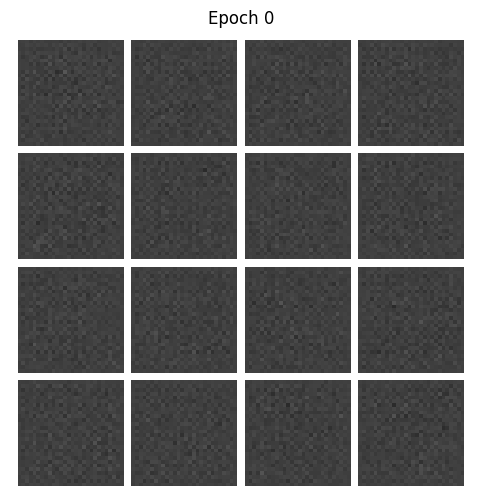

In [19]:
# Show initial untrained Generator output (Epoch 0)
gen_model.eval()
with torch.no_grad():
    samples = create_samples(gen_model, fixed_z, batch_size)  # [B, 1, 28, 28]
    show_generated_images(samples[:16], epoch=0)  # Show Epoch 0

Epoch 001 | D Loss: -10.5601 | G Loss: -0.8329


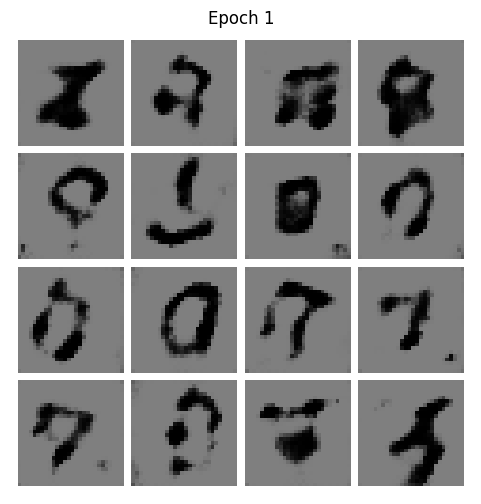

Epoch 002 | D Loss: -4.4782 | G Loss: -0.2236


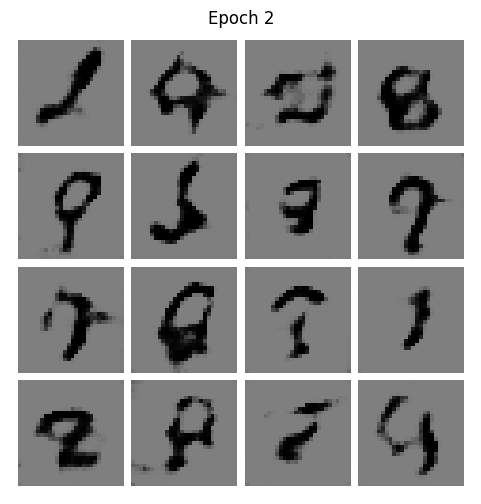

Epoch 003 | D Loss: -3.9487 | G Loss: 0.3161


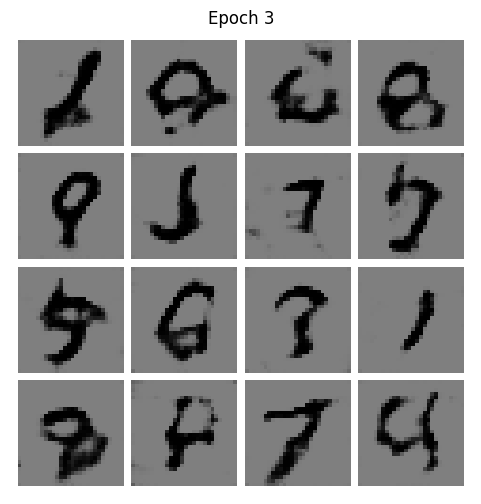

Epoch 004 | D Loss: -3.4228 | G Loss: -0.6694


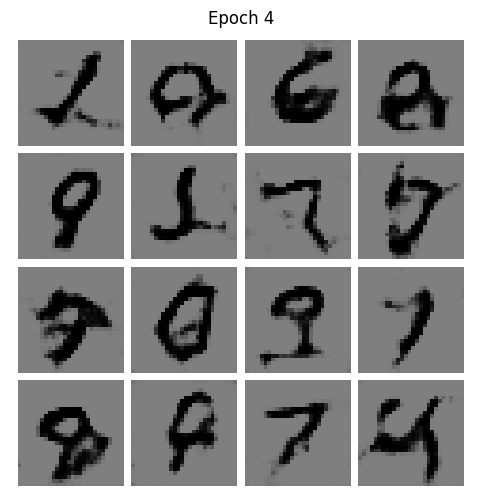

Epoch 005 | D Loss: -3.1512 | G Loss: -0.8490


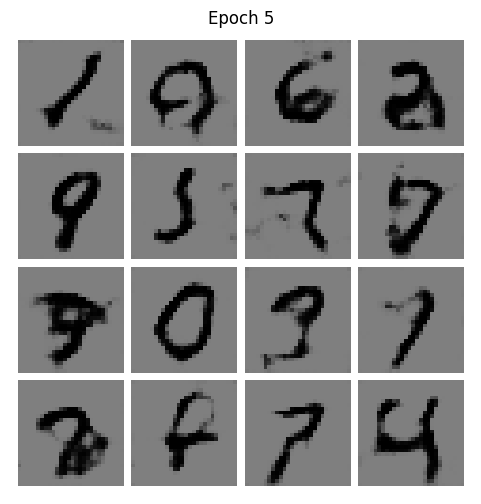

Epoch 006 | D Loss: -2.9417 | G Loss: -0.9492


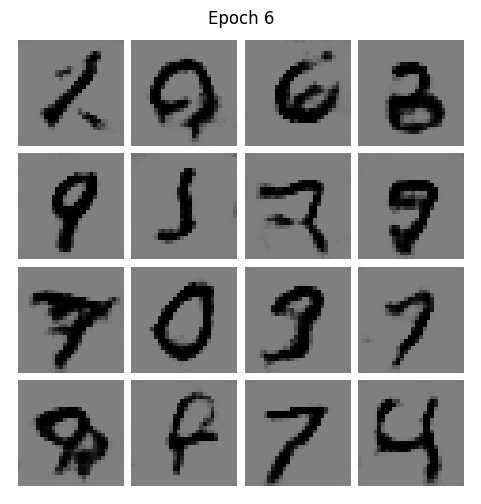

Epoch 007 | D Loss: -2.8161 | G Loss: -0.9566


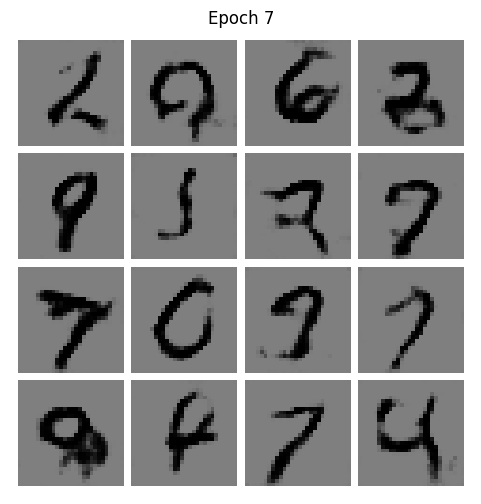

Epoch 008 | D Loss: -2.6094 | G Loss: -1.1840


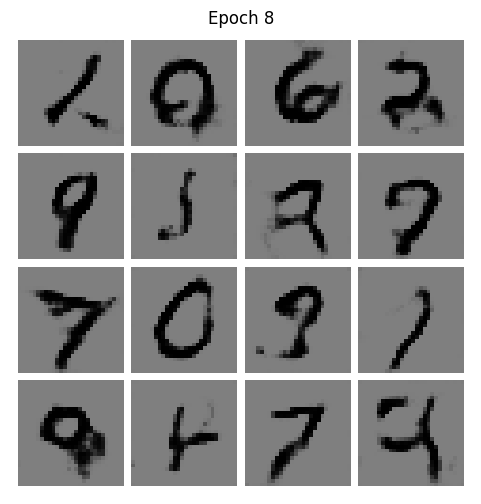

Epoch 009 | D Loss: -2.4763 | G Loss: -1.1030


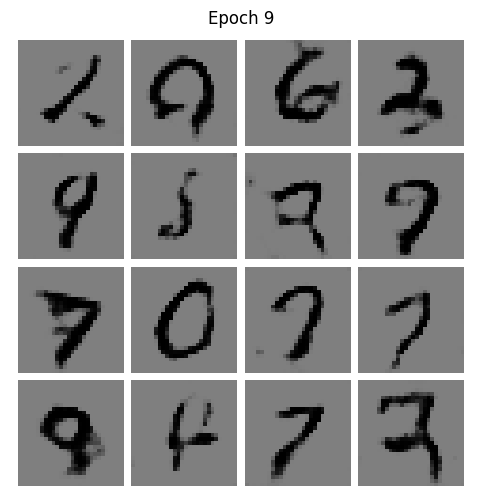

Epoch 010 | D Loss: -2.4654 | G Loss: -0.8249


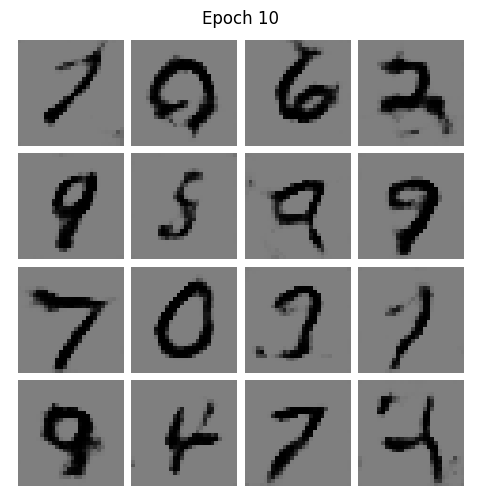

In [ ]:
epoch_samples_wgan = []
lambda_gp = 10.0
num_epochs = 50
torch.manual_seed(1)
critic_iterations = 5


for epoch in range(1, num_epochs+1):

    gen_model.train()
    d_losses, g_losses = [], []

    for i, (x, _) in enumerate(mnist_dl):

        for _ in range(critic_iterations): # This matches the WGAN training strategy of training the Critic more often than the Generator
            d_loss = d_train_wgan(x)       # More Critic updates = better distance estimates = more meaningful Generator updates.

        d_losses.append(d_loss)
        g_losses.append(g_train_wgan(x))

    print(f"Epoch {epoch:03d} | D Loss: {torch.FloatTensor(d_losses).mean():.4f} "
          f"| G Loss: {torch.FloatTensor(g_losses).mean():.4f}")

    # Generate and store samples using a fixed latent vector
    gen_model.eval()
    with torch.no_grad():
        samples = create_samples(gen_model, fixed_z, batch_size)  # Assumes shape [B, 1, H, W]
        epoch_samples_wgan.append(samples.detach().cpu().numpy())

        # Display the first 16 samples visually
        show_generated_images(samples[:16], epoch=epoch)

During middle epochs, we do expect D loss starting to rise (less negative, more hard for the critic to distinguish) and G loss to become more negative (better generation).

A healthy training should be characterized by:

* D loss gradually increases (toward 0)

* G loss gradually decreases (more negative)

* Generated samples become clearer

In [ ]:
"""
selected_epochs = [1, 2, 4, 10, 50]
# selected_epochs = [1, 10, 20, 30, 50, 70]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center',
                transform=ax.transAxes)

        image = epoch_samples_wgan[e-1][j]
        ax.imshow(image, cmap='gray_r')

plt.show()
"""